## Qustion 1

### a)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


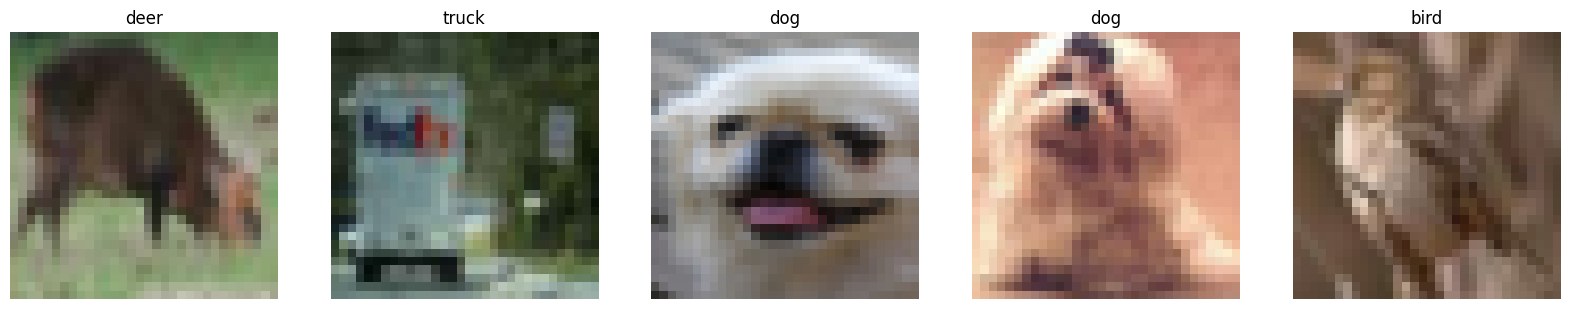

In [16]:
import numpy as np 

dataiter = iter(trainloader)
images, labels = next(dataiter)

# show five images in the training set
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # rearrange dimensions to (H, W, C)
    plt.axis('off')

fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for i in range(5):
    ax = axes[i]
    plt.sca(ax)
    imshow(images[i])
    ax.set_title(classes[labels[i]])
plt.show()


In [13]:
# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Hidden layer size
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w1 = torch.randn(Din, H) * std
b1 = torch.zeros(H)
w2 = torch.randn(H, K) * std
b2 = torch.zeros(K)

# Hyperparameters
iterations = 10
lr = 1e-4  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0.001  # Regularization
loss_history = []

In [14]:
# 3. Training Loop

criterian = nn.CrossEntropyLoss()
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # Convert labels to one-hot

        # Forward pass
        h = torch.sigmoid(x_train.mm(w1) + b1)  # Hidden layer activation
        y_pred = h.mm(w2) + b2  # Output layer activation

        # Loss calculation (Cross-Entropy Loss with regularization)
        loss = criterian(y_pred, labels) + reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dscores = torch.softmax(y_pred, dim=1)
        dscores[range(Ntr), labels] -= 1
        dscores /= Ntr

        dw2 = h.t().mm(dscores) + reg * w2
        db2 = dscores.sum(dim=0)

        dhidden = dscores.mm(w2.t()) * h * (1 - h)
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)
        
        # Parameter update
        with torch.no_grad():
            w1 -= lr * dw1
            b1 -= lr * db1
            w2 -= lr * dw2
            b2 -= lr * db2

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 10, Loss: 2.3026070425510405
Epoch 2 / 10, Loss: 2.3026053540706632
Epoch 3 / 10, Loss: 2.302602827310562
Epoch 4 / 10, Loss: 2.3026022901535033
Epoch 5 / 10, Loss: 2.3026001992225646
Epoch 6 / 10, Loss: 2.302598374843597
Epoch 7 / 10, Loss: 2.302597183227539
Epoch 8 / 10, Loss: 2.302596489191055
Epoch 9 / 10, Loss: 2.302594731092453
Epoch 10 / 10, Loss: 2.3025941274166106


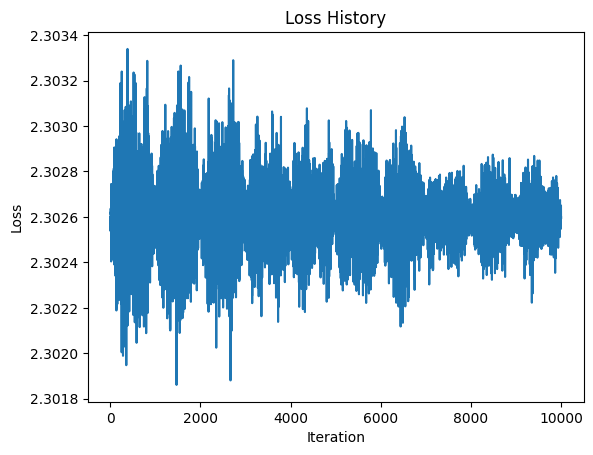

In [15]:
# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [16]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        h1 = torch.sigmoid(x_train.mm(w1) + b1)
        y_train_pred = h1.mm(w2) + b2
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

Training accuracy: 10.00%


In [17]:
# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        h1 = torch.sigmoid(x_test.mm(w1) + b1)
        y_test_pred = h1.mm(w2) + b2
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()
test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 10.00%


## Question 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#convert MNIST image files into a Tensor of 4-dimensions(# of images, height, width, color channels)
transform = transforms.ToTensor()
train_data = datasets.MNIST(root = '/cnn_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root = '/cnn_data', train=False, download=True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [17]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [23]:
class LeNet5(nn.Module):
    def __init__(self) :
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        self.fc1 = nn.Linear(in_features=16 * 4  *4, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        # Convolutional layer
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        
        # Flatten layer
        x = x.view(-1, 16 * 4 * 4) 
        
        # Fully connected layer
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        
        return x

In [24]:
from torchsummary import summary
model = LeNet5()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
            Linear-3                   [-1, 84]          21,588
            Linear-4                   [-1, 10]             850
Total params: 25,010
Trainable params: 25,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.10
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [25]:
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1  #start batch number at 1
        y_pred = model(X_train)
        loss = criterian(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the firdt point
        batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True=1, False=0, sum those up
        train_corr += batch_corr
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print out some results
        if b%1000 == 0:
            print(f"Epoch: {i + 1} Batch: {b} Loss: {loss.item()}")
            
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    #Test
    with torch.no_grad(): # No gradient so we don't update our weights and biases with test data
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            loss = criterian(y_val, y_test)
        
            predicted = torch.max(y_val.data, 1)[1] # adding up the correct predictions
            batch_tst_corr = (predicted == y_test).sum() # how many we got correct from this batch. True=1, False=0, sum those up
            test_corr += batch_tst_corr
            
    test_losses.append(loss)
    test_correct.append(test_corr)

Epoch: 1 Batch: 1000 Loss: 1.4727826118469238
Epoch: 1 Batch: 2000 Loss: 1.461150884628296
Epoch: 1 Batch: 3000 Loss: 1.4611537456512451
Epoch: 2 Batch: 1000 Loss: 1.461213231086731
Epoch: 2 Batch: 2000 Loss: 1.4611501693725586
Epoch: 2 Batch: 3000 Loss: 1.4611859321594238
Epoch: 3 Batch: 1000 Loss: 1.461150884628296
Epoch: 3 Batch: 2000 Loss: 1.4613914489746094
Epoch: 3 Batch: 3000 Loss: 1.521315097808838
Epoch: 4 Batch: 1000 Loss: 1.4652750492095947
Epoch: 4 Batch: 2000 Loss: 1.4611843824386597
Epoch: 4 Batch: 3000 Loss: 1.4614381790161133
Epoch: 5 Batch: 1000 Loss: 1.4611501693725586
Epoch: 5 Batch: 2000 Loss: 1.4611568450927734
Epoch: 5 Batch: 3000 Loss: 1.4611505270004272
Epoch: 6 Batch: 1000 Loss: 1.4611506462097168
Epoch: 6 Batch: 2000 Loss: 1.4611515998840332
Epoch: 6 Batch: 3000 Loss: 1.461301326751709
Epoch: 7 Batch: 1000 Loss: 1.4662725925445557
Epoch: 7 Batch: 2000 Loss: 1.4611501693725586
Epoch: 7 Batch: 3000 Loss: 1.523627519607544
Epoch: 8 Batch: 1000 Loss: 1.52365386486

In [29]:
train_accuracy = train_correct[-1].item() / 60000 * 100
test_accuracy = test_correct[-1].item() / 10000 * 100
print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 99.46%
Test accuracy: 98.70%


## Question 03

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
import copy

# Define transformations for the dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the hymenoptera dataset
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
# Load pre-trained ResNet18 model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Modify the last layer for two classes (ants and bees)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the GPU if available
model_ft = model_ft.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Load pre-trained ResNet18 model
model_fe = models.resnet18(pretrained=True)
num_ftrs = model_fe.fc.in_features

# Freeze all layers
for param in model_fe.parameters():
    param.requires_grad = False

# Replace the last layer
model_fe.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the GPU if available
model_fe = model_fe.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Only parameters of the last layer are optimized
optimizer_fe = optim.SGD(model_fe.fc.parameters(), lr=0.001, momentum=0.9)

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it has the best accuracy on validation
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.5824 Acc: 0.7418
val Loss: 0.2573 Acc: 0.9085

Epoch 2/10
----------
train Loss: 0.5044 Acc: 0.8238
val Loss: 1.0380 Acc: 0.7778

Epoch 3/10
----------
train Loss: 0.5627 Acc: 0.8074
val Loss: 0.3445 Acc: 0.8497

Epoch 4/10
----------
train Loss: 0.7392 Acc: 0.7090
val Loss: 0.2996 Acc: 0.8889

Epoch 5/10
----------
train Loss: 0.5095 Acc: 0.7869
val Loss: 0.3591 Acc: 0.8497

Epoch 6/10
----------
train Loss: 0.6089 Acc: 0.7541
val Loss: 0.5367 Acc: 0.7778

Epoch 7/10
----------
train Loss: 0.6465 Acc: 0.7869
val Loss: 0.5201 Acc: 0.8301

Epoch 8/10
----------
train Loss: 0.2903 Acc: 0.8770
val Loss: 0.2834 Acc: 0.9085

Epoch 9/10
----------
train Loss: 0.2666 Acc: 0.8852
val Loss: 0.2630 Acc: 0.9085

Epoch 10/10
----------
train Loss: 0.2643 Acc: 0.8852
val Loss: 0.2415 Acc: 0.8954

Training complete in 4m 37s
Best val Acc: 0.9085


In [23]:
model_fe = train_model(model_fe, criterion, optimizer_fe, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.5853 Acc: 0.6803
val Loss: 0.5229 Acc: 0.7647

Epoch 2/10
----------
train Loss: 0.4938 Acc: 0.7623
val Loss: 0.2666 Acc: 0.9085

Epoch 3/10
----------
train Loss: 0.4646 Acc: 0.7910
val Loss: 0.1850 Acc: 0.9608

Epoch 4/10
----------
train Loss: 0.4469 Acc: 0.8074
val Loss: 0.1739 Acc: 0.9542

Epoch 5/10
----------
train Loss: 0.6433 Acc: 0.7459
val Loss: 0.3184 Acc: 0.8889

Epoch 6/10
----------
train Loss: 0.5225 Acc: 0.7787
val Loss: 0.2670 Acc: 0.9085

Epoch 7/10
----------
train Loss: 0.3784 Acc: 0.8320
val Loss: 0.1801 Acc: 0.9477

Epoch 8/10
----------
train Loss: 0.4307 Acc: 0.8320
val Loss: 0.2447 Acc: 0.9150

Epoch 9/10
----------
train Loss: 0.3871 Acc: 0.8156
val Loss: 0.2165 Acc: 0.9281

Epoch 10/10
----------
train Loss: 0.4681 Acc: 0.8238
val Loss: 0.1991 Acc: 0.9477

Training complete in 3m 17s
Best val Acc: 0.9608
